# Create dataset of expressions for training similar-expressions model

## Using custom generator (based on NeSymRes and DLSM code)

Creates .txt file with string expressions.

In [226]:
from importlib import reload
from custom import utils, generator, dclasses
reload(generator)
reload(utils)
reload(dclasses)
from custom.utils import create_generator
import os
import numpy as np
np.random.seed(2)

gen, params = create_generator('./custom/data_settings.json')
# gen.generate_equation(np.random, -1e3, 1e3, simplify=False, check_const_range=True)

In [ ]:
# Generate data
expressions = [gen.generate_equation(np.random, -1, 1, simplify=False, check_const_range=True) for _ in range(100000)]

In [227]:
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'

# Filter out empty strings
expressions = [expr for expr in expressions if expr]

# Save
output_file = os.path.join(datapath, 'expr_240807_5.txt')
with open(output_file, 'w') as f:
    for expr in expressions:
        f.write(f"{expr}\n")

## Parse string to onehot representation

### Whole dataset

In [7]:
import pandas as pd
import h5py
from parsing import parse_dataset
from model.grammar import GCFG

In [4]:
# Load data
datapath = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data/expr_240807_5.txt'
with open(datapath, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

# Parse dataset
onehot, invalid, consts = parse_dataset(eqs)

# Save parsed dataset
with h5py.File(f'{datapath[:-4]}-parsed.h5', 'w') as f:
    f.create_dataset('data', data=onehot)
    f.create_dataset('invalid_indices', data=invalid)

In [ ]:
a = [float(const) for const_list in consts for const in const_list]
s = pd.Series(a)
s.describe()

In [2]:
from importlib import reload
from model import util
reload(util)
from model.util import plot_onehot

plot_onehot(onehot[3, ...], GCFG)

ModuleNotFoundError: No module named 'model'

# Create value dataset

In [ ]:
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [150]:
from model.util import load_raw_parsed_data

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
name = 'expr_240807_5'
eqs, onehot = load_raw_parsed_data(datapath, name)

In [67]:
eqs.shape

(93322,)

In [68]:
import sympy as sp

MAX_ABS_VAL = 1e5

x = np.linspace(-10, 10, 100)
y = np.empty((len(eqs), len(x)))

import multiprocess as mp

def process_equation(args):
    eq, x = args
    expr = sp.sympify(eq)
    return [expr.evalf(subs={sp.Symbol('x1'): val}) for val in x]


with mp.Pool() as pool:
    results = pool.map(process_equation, [(eq, x) for eq in eqs])

y = np.array(results).astype(np.float32)

invalid = np.any(np.isinf(y) | (np.abs(y) > MAX_ABS_VAL), axis=1)
invalid.sum() / len(invalid)

values = y[~invalid]


In [151]:
import h5py

# Save parsed dataset
with h5py.File(f'{datapath}/{name}-values.h5', 'w') as f:
    f.create_dataset('data', data=values)
    f.create_dataset('invalid_indices', data=invalid)

## Evaluated value distribution

In [123]:
import pandas as pd

a = pd.Series(y[~invalid].flatten())
a.describe()

count    8.412000e+06
mean     1.089742e+02
std      1.567060e+03
min     -9.844108e+04
25%     -5.092065e-01
50%      4.271007e-01
75%      2.682249e+00
max      9.959591e+04
dtype: float64

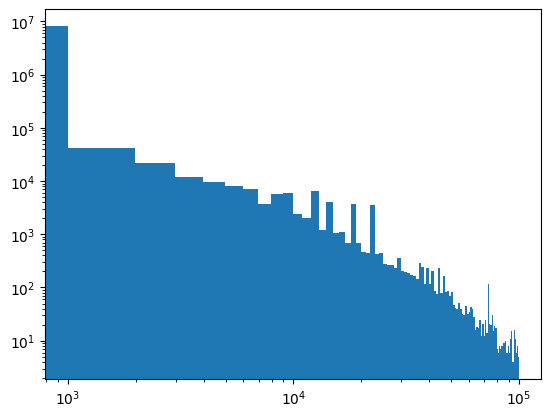

In [129]:
from matplotlib import pyplot as plt

plt.hist(a.abs(), bins=100)
plt.yscale('log')
plt.xscale('log')

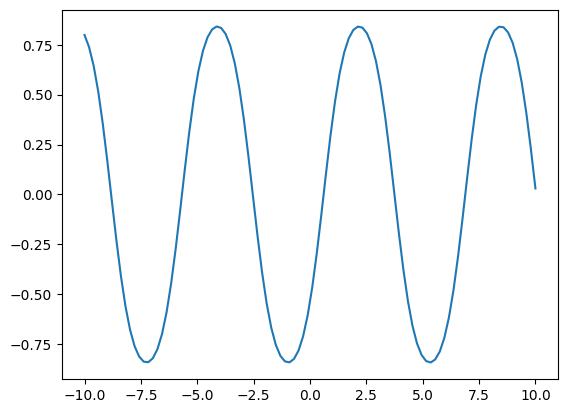

In [146]:
# Example function
plt.plot(x, y[~invalid, :][15].T)